In [1]:
#!nvidia-smi

In [2]:
## Launch video - https://www.youtube.com/watch?v=_BghEK_4U2A
# Description - Falcon 9 Launch - May 2, 2024, Worldview 1 and 2
# Duration - 29.00 - 29.30 , 29.40 - 31.00 

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/gaganyatri/code/external/segment-anything-2


In [4]:
#!ffmpeg -i videos/video-720.mp4 -ss 00:29:18 -to 00:29:30 videos/video-720-part1.mp4


In [5]:
#!ffmpeg -i videos/video-720.mp4 -ss 00:29:40 -to 00:31:00 videos/video-720-part2.mp4

In [6]:
'''
import cv2
from IPython.display import Image, display

# Open the video file
video_path = "videos/video-720-part1.mp4"
cap = cv2.VideoCapture(video_path)
output_path = "videos/first_frame_720.jpg"
# Read the first frame
ret, frame = cap.read()

if ret:
    # Convert the frame from BGR to RGB color space
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Encode the frame as JPEG
    _, buffer = cv2.imencode('.jpg', frame_rgb)

    cv2.imwrite(output_path, frame)
    
    # Display the image
    display(Image(data=buffer.tobytes()))
else:
    print("Failed to read the video file.")

# Release the video capture object
cap.release()
'''

'\nimport cv2\nfrom IPython.display import Image, display\n\n# Open the video file\nvideo_path = "videos/video-720-part1.mp4"\ncap = cv2.VideoCapture(video_path)\noutput_path = "videos/first_frame_720.jpg"\n# Read the first frame\nret, frame = cap.read()\n\nif ret:\n    # Convert the frame from BGR to RGB color space\n    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)\n    \n    # Encode the frame as JPEG\n    _, buffer = cv2.imencode(\'.jpg\', frame_rgb)\n\n    cv2.imwrite(output_path, frame)\n    \n    # Display the image\n    display(Image(data=buffer.tobytes()))\nelse:\n    print("Failed to read the video file.")\n\n# Release the video capture object\ncap.release()\n'

In [7]:
#!pip install -q supervision[assets] jupyter_bbox_widget

In [8]:
#!mkdir -p {HOME}/checkpoints

In [9]:
#!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints

In [10]:
## Image Segment

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [11]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [12]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [13]:
image = Image.open('videos/first_frame_720.jpg')
image = np.array(image.convert("RGB"))

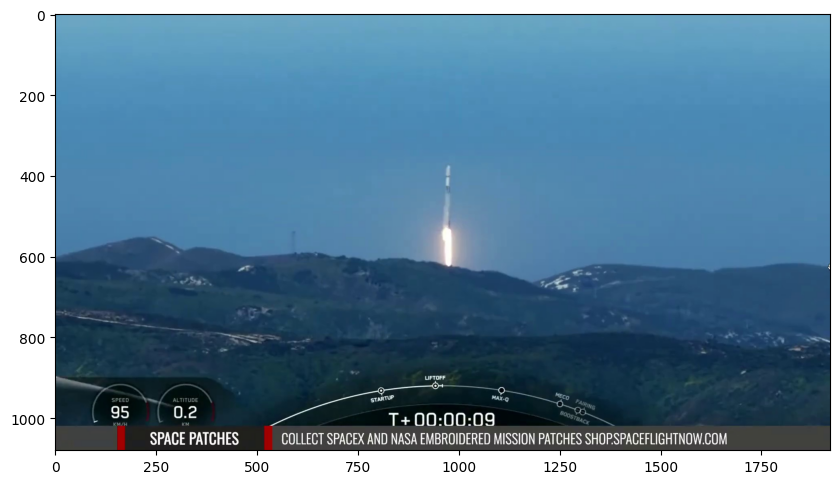

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [15]:
sam2_checkpoint = "checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

In [16]:
predictor.set_image(image)

In [17]:
input_point = np.array([[980, 500]])
input_label = np.array([1])

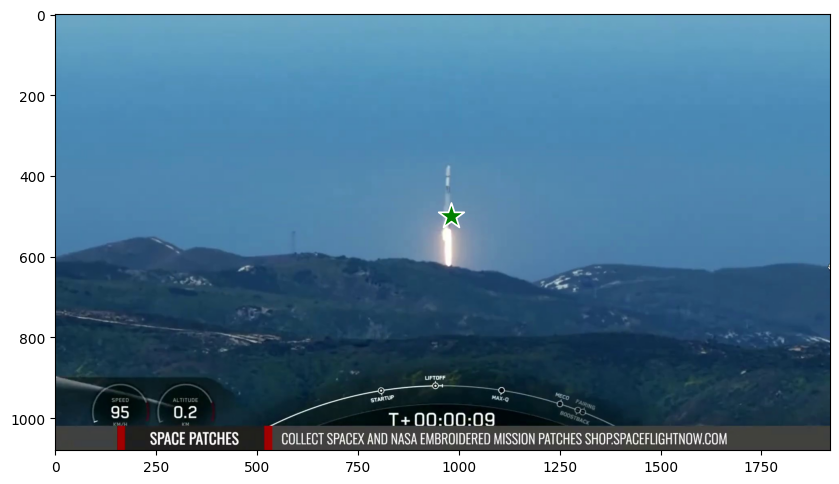

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

In [19]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [20]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]


In [21]:
masks.shape  # (number_of_masks) x H x W

(3, 1080, 1920)

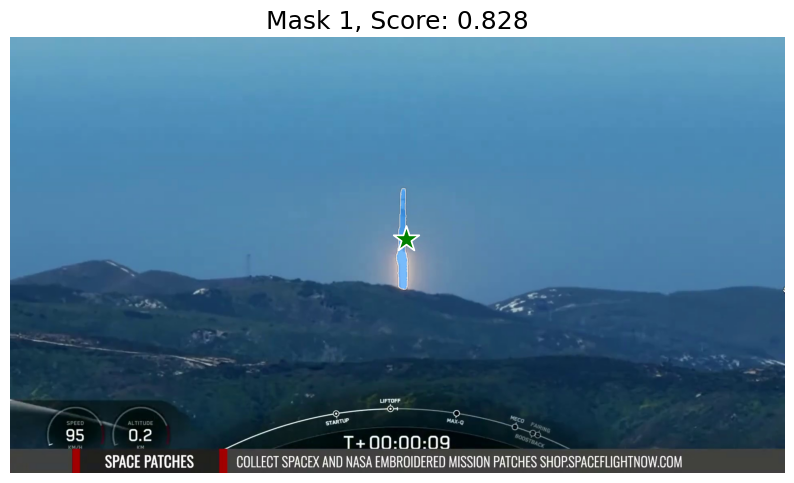

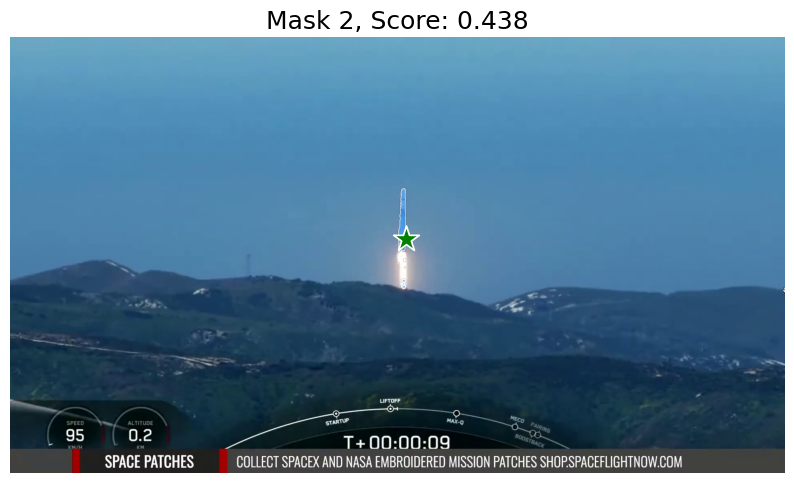

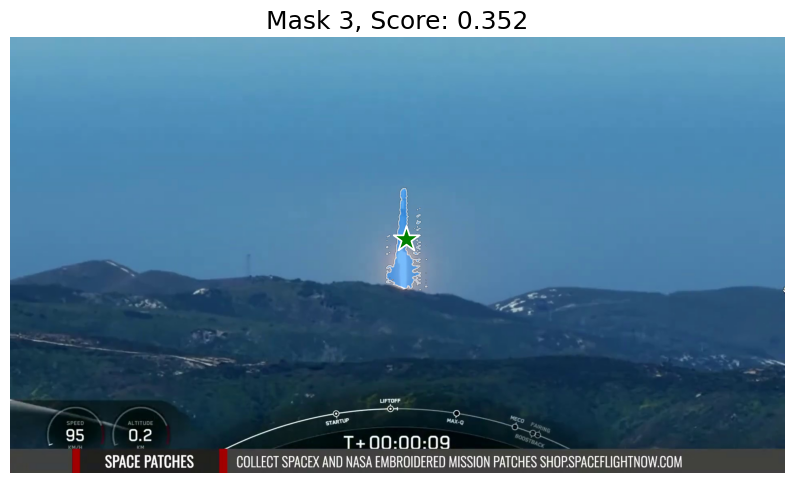

In [22]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)